In [5]:
import pandas as pd
import numpy as np
import joblib
import matplotlib.pyplot as plt
import seaborn as sns
import optuna
import shap
from sklearn.inspection import permutation_importance
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, r2_score
from sklearn.preprocessing import PowerTransformer
from sklearn.feature_selection import RFECV
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV

In [6]:
df = pd.read_csv('../../../data/preprocessed/realestates_kh_Pearson_v2.csv')

In [7]:
df.isnull().sum()

land_area               0
is_parent               0
latitude                0
longitude               0
population              0
                       ..
h_id_886586a691fffff    0
h_id_886586a693fffff    0
h_id_886586a699fffff    0
h_id_886586a69bfffff    0
price_per_m2            0
Length: 484, dtype: int64

In [8]:
X = df.drop(['price_per_m2'], axis=1)
y = df['price_per_m2']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

In [9]:
target_transformer = PowerTransformer(method='yeo-johnson')
y_train_trans = target_transformer.fit_transform(y_train.values.reshape(-1, 1)).flatten()
y_test_trans = target_transformer.transform(y_test.values.reshape(-1, 1)).flatten()

In [10]:
# For inverse transform
def inverse_transform(y_trans):
    return target_transformer.inverse_transform(y_trans.reshape(-1, 1)).flatten()

In [11]:
# Initialize Random Forest model
rf_model = RandomForestRegressor(random_state=42, n_jobs=-1)

In [12]:
# Enhanced parameter grid for Random Forest
param_grid = {
    'n_estimators': [300, 500, 800, 1000],
    'max_depth': [None, 10, 20, 30, 40],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 0.8, 'log2', None],
    'bootstrap': [True, False],
    'max_samples': [0.6, 0.8, None]
}

In [13]:
# Hyperparameter tuning with RandomizedSearchCV
print("Starting RandomizedSearchCV for Random Forest...")
rf_search = RandomizedSearchCV(
    rf_model,
    param_distributions=param_grid,
    n_iter=50,
    cv=5,
    scoring='r2',
    n_jobs=-1,
    verbose=1,
    random_state=42
)

rf_search.fit(X_train, y_train_trans)

Starting RandomizedSearchCV for Random Forest...
Fitting 5 folds for each of 50 candidates, totalling 250 fits


d:\anaconda\envs\env_v3.10\lib\site-packages\sklearn\model_selection\_validation.py:528: FitFailedWarning: 
85 fits failed out of a total of 250.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
85 fits failed with the following error:
Traceback (most recent call last):
  File "d:\anaconda\envs\env_v3.10\lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "d:\anaconda\envs\env_v3.10\lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "d:\anaconda\envs\env_v3.10\lib\site-packages\sklearn\ensemble\_forest.py", line 431, in fit
    raise ValueError(
ValueError: `max_sample` cannot be set i

RandomizedSearchCV(cv=5,
                   estimator=RandomForestRegressor(n_jobs=-1, random_state=42),
                   n_iter=50, n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [None, 10, 20, 30, 40],
                                        'max_features': ['sqrt', 0.8, 'log2',
                                                         None],
                                        'max_samples': [0.6, 0.8, None],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [300, 500, 800, 1000]},
                   random_state=42, scoring='r2', verbose=1)

In [14]:
# Get best model and parameters
tuned_rf = rf_search.best_estimator_
best_params = rf_search.best_params_
print(f"Best R² from RandomizedSearchCV: {rf_search.best_score_:.4f}")
print(f"Best parameters: {best_params}")

Best R² from RandomizedSearchCV: 0.4979
Best parameters: {'n_estimators': 1000, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_samples': 0.6, 'max_features': None, 'max_depth': 30, 'bootstrap': True}


In [15]:
# Inverse transform function (already defined in your notebook)
# def inverse_transform(y_trans):
#     return target_transformer.inverse_transform(y_trans.reshape(-1, 1)).flatten()

# Predict on test set (transformed target)
y_pred_test_trans = tuned_rf.predict(X_test)

# Inverse transform predictions and true values
y_pred_test = inverse_transform(y_pred_test_trans)
y_test_actual = inverse_transform(y_test_trans)

# Calculate metrics
r2 = r2_score(y_test_actual, y_pred_test)
mae = mean_absolute_error(y_test_actual, y_pred_test)
mape = np.mean(np.abs((y_test_actual - y_pred_test) / np.maximum(y_test_actual, 1e-8))) * 100  # Avoid division by zero

print(f"Test R²: {r2:.4f}")
print(f"Test MAE: {mae:.2f}")
print(f"Test MAPE: {mape:.2f}%")
print(f"Test Avg Price: {y_test_actual.mean():.2f}")

Test R²: 0.4085
Test MAE: 754.91
Test MAPE: 38.67%
Test Avg Price: 2446.87


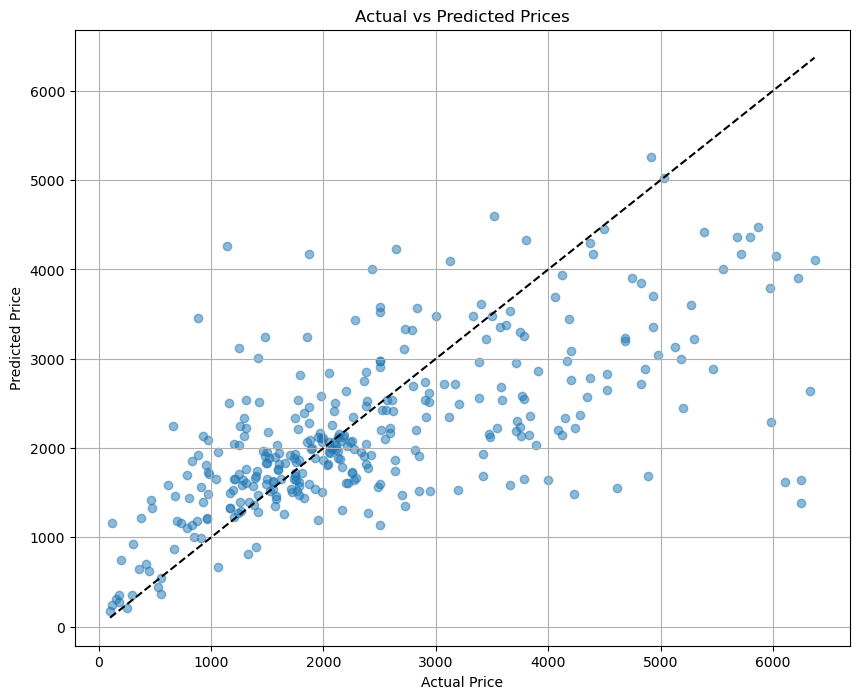

In [16]:
# Predict on test set
y_pred_test_trans = tuned_rf.predict(X_test)
y_pred_test = inverse_transform(y_pred_test_trans)
y_test_actual = inverse_transform(y_test_trans)

# Plot actual vs predicted
def plot_actual_vs_predicted(y_true, y_pred):
    plt.figure(figsize=(10, 8))
    plt.scatter(y_true, y_pred, alpha=0.5)
    plt.plot([y_true.min(), y_true.max()], 
             [y_true.min(), y_true.max()], 'k--')
    plt.xlabel('Actual Price')
    plt.ylabel('Predicted Price')
    plt.title('Actual vs Predicted Prices')
    plt.grid(True)
    plt.savefig("rf_actual_vs_predicted.png")
    plt.show()

plot_actual_vs_predicted(y_test_actual, y_pred_test)

In [17]:
# # Feature selection with RFECV
# print("\nPerforming feature selection with RFECV...")
# selector = RFECV(
#     estimator=tuned_rf,
#     step=1,
#     cv=5,
#     scoring='r2',
#     min_features_to_select=15,
#     n_jobs=-1
# )

# selector.fit(X_train, y_train_trans)
# selected_features = X_train.columns[selector.support_]
# print(f"Selected {len(selected_features)} features:")
# print(selected_features.tolist())

In [18]:
# # Update datasets with selected features
# X_train_sel = X_train[selected_features]
# X_test_sel = X_test[selected_features]

In [19]:
def objective(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 300, 1500),
        'max_depth': trial.suggest_int('max_depth', 5, 50),
        'min_samples_split': trial.suggest_int('min_samples_split', 2, 20),
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 10),
        'max_features': trial.suggest_categorical('max_features', ['sqrt', 'log2', 0.7, 0.8, 0.9]),
        'bootstrap': trial.suggest_categorical('bootstrap', [True, False]),
    }
    # Only set max_samples if bootstrap is True
    if params['bootstrap']:
        params['max_samples'] = trial.suggest_float('max_samples', 0.6, 0.95)
    else:
        params['max_samples'] = None

    model = RandomForestRegressor(**params, random_state=42, n_jobs=-1)
    score = cross_val_score(
        model, 
        X_train, 
        y_train_trans, 
        cv=5, 
        scoring='r2', 
        n_jobs=-1
    ).mean()
    return score

print("\nStarting Optuna optimization...")
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=50)

[I 2025-06-24 08:25:18,865] A new study created in memory with name: no-name-ba581a72-c21b-4cd2-92a9-385fe0c5d7a8



Starting Optuna optimization...


[I 2025-06-24 08:25:23,524] Trial 0 finished with value: 0.4206852776180021 and parameters: {'n_estimators': 736, 'max_depth': 17, 'min_samples_split': 9, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'bootstrap': False}. Best is trial 0 with value: 0.4206852776180021.
[I 2025-06-24 08:25:54,878] Trial 1 finished with value: 0.43117995010726745 and parameters: {'n_estimators': 451, 'max_depth': 23, 'min_samples_split': 19, 'min_samples_leaf': 4, 'max_features': 0.9, 'bootstrap': False}. Best is trial 1 with value: 0.43117995010726745.
[I 2025-06-24 08:25:57,468] Trial 2 finished with value: 0.1840740197862186 and parameters: {'n_estimators': 459, 'max_depth': 6, 'min_samples_split': 6, 'min_samples_leaf': 2, 'max_features': 'log2', 'bootstrap': True, 'max_samples': 0.907906933470674}. Best is trial 1 with value: 0.43117995010726745.
[I 2025-06-24 08:26:24,513] Trial 3 finished with value: 0.4705520883522391 and parameters: {'n_estimators': 908, 'max_depth': 8, 'min_samples_split': 6, 

In [20]:
# Create optimized model
optimized_params = study.best_params
optimized_rf = RandomForestRegressor(**optimized_params, random_state=42, n_jobs=-1)
optimized_rf.fit(X_train, y_train_trans)

RandomForestRegressor(max_depth=32, max_features=0.8,
                      max_samples=0.9098219838248506, min_samples_split=11,
                      n_estimators=393, n_jobs=-1, random_state=42)

In [21]:
# Final evaluation function
def evaluate_model(model, X, y_true_trans):
    y_pred_trans = model.predict(X)
    y_pred = inverse_transform(y_pred_trans)
    y_true = inverse_transform(y_true_trans)
    
    r2 = r2_score(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    mape = np.mean(np.abs((y_true - y_pred) / np.maximum(y_true, 1e-8))) * 100
    
    print(f"R²: {r2:.4f}")
    print(f"MAE: {mae:.2f}")
    print(f"MAPE: {mape:.2f}%")
    print(f"Avg Price: {y_true.mean():.2f}")
    
    return y_pred

In [22]:
# Evaluate on test set
print("\nOptimized Random Forest Performance:")
y_pred_optimized = evaluate_model(optimized_rf, X_test, y_test_trans)


Optimized Random Forest Performance:
R²: 0.4247
MAE: 750.50
MAPE: 38.38%
Avg Price: 2446.87


In [23]:
# # Model interpretation with SHAP
# print("\nGenerating SHAP explanations...")
# explainer = shap.TreeExplainer(optimized_rf)
# shap_values = explainer.shap_values(X_test)

In [24]:
# # Summary plot
# shap.summary_plot(shap_values, X_test, plot_type="bar")
# plt.title("Feature Importance (SHAP)")
# plt.tight_layout()
# plt.savefig("rf_shap_summary.png")
# plt.show()

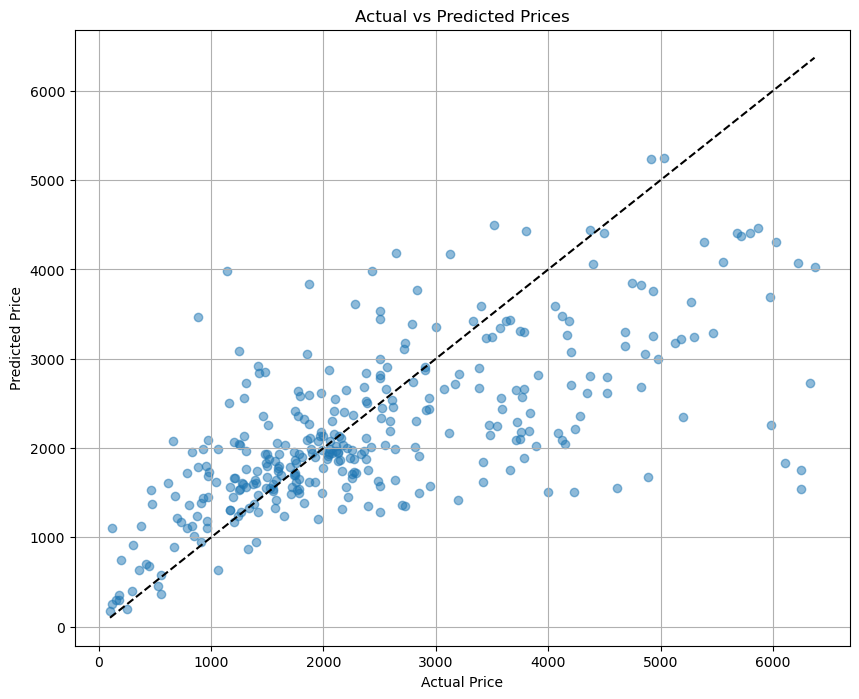

In [25]:
def plot_actual_vs_predicted(y_true, y_pred):
    plt.figure(figsize=(10, 8))
    plt.scatter(y_true, y_pred, alpha=0.5)
    plt.plot([y_true.min(), y_true.max()], 
             [y_true.min(), y_true.max()], 'k--')
    plt.xlabel('Actual Price')
    plt.ylabel('Predicted Price')
    plt.title('Actual vs Predicted Prices')
    plt.grid(True)
    plt.savefig("rf_actual_vs_predicted.png")
    plt.show()

y_test_actual = inverse_transform(y_test_trans)
plot_actual_vs_predicted(y_test_actual, y_pred_optimized)